## Постановка задачи

### Клиент
Сервис Repetit.ru

### Цель
Создать ML-продукт, который обрабатывает новые заявки на репетитора и предсказывает, будет ли оплачена заявка.

### Известные проблемы
- В базе данных заказчика хранятся не только новые заявки, но и те, по которым уже совершены действия (например, клиент уже нашёл репетитора и оплатил его услуги). Таким образом, если ML-модель будет хорошо справляться с уже обработанными заявками, она может показать хороший результат, но будет по сути бесполезна.
- В базе данных присутствуют "дубли" заявок. То есть, если по тем или иным причинам клиент хочет связаться с другим репетитором, создаётся новая заявка, так как в одной заявке может быть только один репетитор. Согласно заданию, в случае если оплачена хотя бы одна из дублирующих заявок, то все остальные заявки из данной группы считаются также оплаченными.

### Описание проекта и pipeline решения

#### Табицы данных
- orders.feather - основная таблица, содержащая информацию о заявках.
- suitable_teachers.feather - таблица данных, содержащая список учителей по фильтру для конкретной заявки.
- teachers_info.feather - таблица с информацией об учителях.
- prefered_teachers_order_id - таблица с информацией о предпочтительных учителях (не используется)

#### Pipeline решения
- Ознакомление с данными, агреггирование таблиц
- Работа с пропусками, выбросами и "испорченными" данными. Очистка данных.
- Работа с дублирущими заявками (присвоение им соответствующего целевого значения)
- Удаление лишних столбцов (несущих в себе утечку данных и признанных лишними при предварительном анализе)
- Создание искуственных признаков, общих для всей таблицы.
- Работа с датами и текстовыми данными
- Создание искуственных признаков, требующих предварительного разделение выборки на обучающую и тестовую
- Поиск лучших гиперпараметров для модели
- Отбор признаков с помощью shap
- Окончательное обучение модели и вывод


## Импорт модулей и назначение констант

Импортируем необходимые модули

In [1]:
import pandas as pd
import numpy as np


from tqdm.notebook import tqdm
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import shap
from sklearn.model_selection import GridSearchCV
from datetime import date

Прописываем константы.
- <b>TARGET_NUMBERS</b> - те значения status_id, которые являются целевыми
- <b>COLUMNS_TO_DROP</b> - столбцы, которые мы в дальнейшем удалим. Столбцы start_date, comments, estimated_fee, first_lesson_date, lesson_place, working_teacher_id, additional_status_id, prefered_teacher_id, payment_date, status_id, amount_to_pay, client_id приводят к утечке данных, и они будут удалены после анализа данных. Столбец original_order_id будет также удалён, но позже других столбцов, потому он не указан в константе. Также, в констнту попали некоторые столбцы, которые будут удалены по причинам, не связанным с утечкой данных.
- <b>OVERSAMPLING</b> - параметр, связанный с борьбой с дисбалансом. В ходе поиска лучшего решения, было установлено, что для лучших результатов в рамках поставленной задачи лучше всего использовать метод Upsampling, более того, не просто уравнять количество данных в разных классах, а создать искуственный дисбаланс в иную сторону, т.е. сделать так, чтобы на обучающей выборке было больше данных с target = 1. Значение OVERSAMPLING - целове число, показывающее во сколько раз данных с target = 1 должно быть больше, чем данных с target = 0. Значение должно быть целым, начиная с 1. Оптимальным является 2. 

In [2]:
TARGET_NUMBERS = [5,6,13,15]
COLUMNS_TO_DROP = ['payment_date', 'amount_to_pay', 'first_lesson_date', 'additional_status_id',  
                   'estimated_fee', 'teacher_experience_to', 'chosen_teachers_only', 'prefered_teacher_id', 'lesson_place', 'max_metro_distance', 'status_id', 'working_teacher_id', 'start_date', 'comments', 'client_id',
                   'add_info', 'lesson_place']
OVERSAMPLING = 2

Пропишем также ссылки на данные

In [3]:
DATA_PATH_ORDERS = "./data/orders.feather"
DATA_PATH_SUITABLE = "./data/suitable_teachers.feather"
DATA_PATH_TINFO = "./data/teachers_info.feather"

## Первичная обработка данных

Для начала нам нужно загрузить данные и объединить таблицы таким образом, чтобы мы могли получить дополнительные полезные признаки для обучения модели. На данном этапе мы не будем удалять никакие признаки, так как они пригодятся для дальнейшего анализа.

Загружаем данные

In [4]:
df = pd.read_feather(DATA_PATH_ORDERS)
print('Длина основной таблицы:', len(df))
df_suitable = pd.read_feather(DATA_PATH_SUITABLE)
print('Длина таблицы с походящими по фильтру репетиторами: ',len(df_suitable))
df_tinfo = pd.read_feather(DATA_PATH_TINFO)
print('Длина таблицы с инфомацией о репетиторах: ',len(df_tinfo))

#Для дальнейшего исследования нам нужно запомнить оригинальную длину таблицы, до обработки.
original_df_len = len(df)

#Установим опцию, чтобы мы могли видеть все колонки в таблице
pd.set_option('display.max_columns', None) 


Длина основной таблицы: 1191861
Длина таблицы с походящими по фильтру репетиторами:  20271186
Длина таблицы с инфомацией о репетиторах:  307972


Целевая таблица данных - <b>orders.feather</b>, содержащая информацию о заявках на репетитора. Однако, для того, чтобы получить больше полезных признаков, мы будем использовать данные из таблиц suitable_teachers.feather и teachers_info.feather. Таблица suitable_teachers.feather содержит информацию обо всех учителях, которые подходят под критерий данной конкретной заявки (id учителя, статус и т.п.), а teachers_info.feather - данные о конкретном учителе (возраст и так далее). Проблема в том, что мы не можем использовать эти таблицы напрямую, так как с каждым заказом соотносится разное количество учителей. Но мы можем сагреггировать данные из этих таблиц. Для этого надо посмотреть на таблицу с информацией об учителях, выделить те данные, которые мы сможем сагреггировать, объединить эту таблицу с df_suitable, сгруппировать по id заказа, а затем объеденить с основной таблицей.

In [5]:
#Посмотрим на таблицу с информацией об учителях.
df_tinfo.head(1)

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.5,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173


Мы видим большое количество данных, связанных с каждым конкретным учителем. Мы будем использовать среднее значение данных по всем доступным учителям для каждой конкретной заявки. Таким образом, нам подойдут те данные, которые представляют собой либо числовые данные, либо бинарные категориальные. Числовые признаки мы можем вытащить также из признаков связанных с датами, а именно возраст и date_update. 

In [6]:
# Переведём дату рождения в формат даты.
df_tinfo['birth_date'] = pd.to_datetime(df_tinfo['birth_date'], errors="coerce")
# Вычислим возраст учителя. Мы специально используем не настоящий момент, а фиксированную дату, иначе при добавлении новых учителей или заявок, возраст будет меняться и модедб отработает некорректно.
df_tinfo["age"] = (pd.to_datetime("2024-03-01 00:00:00.000")  - df_tinfo["birth_date"]) . dt . days / 365

#Делаем то же самое для date_update
df_tinfo['date_update'] = pd.to_datetime(df_tinfo['date_update'], errors="coerce")
df_tinfo["days_update"] = (pd.to_datetime("today") + pd.DateOffset(months=1) - df_tinfo["date_update"]) . dt . days 

#Теперь запишем те столбцы, которые мы будем использовать в дальнейшем.
TINFO_MEAN = ['lesson_cost',  'review_num', 'star_rating', 'verification_status_id', 'is_email_confirmed', 'is_home_lessons', 'is_external_lessons', 'rating_for_users_yesterday', 'age' , 'days_update']

#Преобразуем этот датасет, оставив только те колонки, которые мы будем использовать для агреггирования, а также добавим "id", так как он нам понадобится для соединения с таблицей df_suitable
df_tinfo = df_tinfo[TINFO_MEAN + ['id']]

#Переименуем id в teacher_id чтобы объединить таблицы в дальнейшем.
df_tinfo = df_tinfo.rename(columns = {'id':'teacher_id'})

#Посмотрим на результат
df_tinfo.head(1)

,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,teacher_id
0,1000,6,4.5,1,0,0,0,1138.0,40.767123,125,33


Как видим, нам удалось корректно обработать даты и оставить только нужные столбцы. Теперь нам нужно посмотреть на таблицу  suitable_teachers и объединить с ней таблицу df_tinfo

In [7]:

df_suitable.head()

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


В этой таблице мы видим такие поля, как teacher_id, order_id, contact_result, enable_auto_assign и enable_assign. В ТЗ сказано, что enable_auto_assign и enable_assign известны на момент подачи заявки. Мы будем использовать среднее значение этих признаков для каждой заявки, а также общее количество доступных по фильтру учителей из этой таблицы и отобранные признаки из предыдущей. 

Так как все данные из df_tinfo мы будем усреднять, создадим словарь автоматически, чтобы не заполнять руками. 

In [8]:
#Инициализируем словарь
tinfo_mean_dict = {}
#Заполняем словарь, в котором ключами будут отобранные из tinfo признаки, а значениями будут 'mean'
for i in TINFO_MEAN:
    tinfo_mean_dict[i] = 'mean'
#Посмотрим на получившийся словарь
tinfo_mean_dict

{'lesson_cost': 'mean',
 'review_num': 'mean',
 'star_rating': 'mean',
 'verification_status_id': 'mean',
 'is_email_confirmed': 'mean',
 'is_home_lessons': 'mean',
 'is_external_lessons': 'mean',
 'rating_for_users_yesterday': 'mean',
 'age': 'mean',
 'days_update': 'mean'}

Теперь нам нужно объединить df_suitable с df_tinfo и подготовить к объединению с основной таблицей.

In [9]:
#Создаём вручную словарь с признаками из df_suitable, которые мы будем агреггировать. 
agg_dict = {'teacher_id': 'count', 'enable_auto_assign': 'mean', 'enable_assign':'mean'}
#Объединяем его с автоматически созданным ранее словарём.
agg_dict = {**agg_dict, **tinfo_mean_dict}
#Убираем contact_result, так как этот признак может нести в себе утечку данных, к тому же его не получится сагреггировать.
df_suitable = df_suitable.drop(columns = ['contact_result'])
#Объединяем таблицы
df_suitable = df_suitable.merge(df_tinfo, on = 'teacher_id', how = 'left')
#Агреггируем наши признаки
df_suitable = df_suitable.groupby(by = 'order_id').agg(agg_dict)
df_suitable = df_suitable.reset_index()
#Переименовываем признаки и готовим к объединению с основной таблицей
df_suitable = df_suitable.rename(columns = {'teacher_id':'suitable_teachers_count'})
df_suitable = df_suitable.rename(columns = {'order_id':'id'})

#Смотрим на результат
df_suitable.head()

,id,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update
0,1742638,13,0.538462,0.000000,776.923077,6.307692,4.715445,2.461538,0.0,0.461538,0.846154,1022.000000,28.047418,253.076923
1,1742639,1,1.000000,1.000000,1000.000000,6.000000,4.898438,3.000000,0.0,0.000000,1.000000,805.500000,34.994521,155.000000
2,1742650,3,0.666667,0.333333,133.333333,2.333333,4.766927,0.000000,0.0,0.666667,1.000000,591.500000,37.416438,126.666667
3,1742651,3,1.000000,0.000000,1533.333333,15.666667,4.966146,1.333333,0.0,0.000000,0.666667,1387.333374,48.053881,225.000000
4,1742654,4,0.750000,0.000000,775.000000,6.500000,4.799805,0.500000,0.0,1.000000,0.750000,603.125000,41.860274,275.750000


Теперь объединим получившуюся таблицу с основной.

In [10]:
df = df.merge(df_suitable, on = 'id', how = 'left')

Далее нам нужно добавить целевой признак к основной таблице. 

In [11]:

df['target'] = df['status_id'].apply(lambda x: 1 if x in TARGET_NUMBERS else 0)


Перед тем, как приступать к дальнейшему анализу и обработке данных, удалим явные дубликаты.

In [12]:
print('До удаления:',df.duplicated().sum() )
df.drop_duplicates(inplace=True)
print('После удаления:',df.duplicated().sum() )

До удаления: 900


После удаления: 0


Как видим, в таблице было 900 явных дубликатов.

### Вывод
Мы получили итоговую таблицу, с которой будем работать в дальнейшем. Далее нам нужно будет проанализировать получившиеся данные и удалить некоторые столбцы.

## Анализ и подготовка данных


Теперь у нас имеется несколько задач:

- Проанализировать пропуски
- Решить проблему с дублирующими заявками

- Проверить данные на выбросы и аномалии
- Убрать лишние признаки (в том числе те, которые могут быть известны только тогда, когда целевой признак уже известен, например, собственно status_id)
- Преобразовать данные в формат, пригодный для ML-модели (заполнить пропуски, обработать категориальные признаки и т.п.) 


Для начала посмотрим на данные

In [13]:

display(df.head())
df.info(max_cols = 52)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1,5.0,0.0,0.2,574.0,26.200000,4.918750,2.400000,0.0,1.000000,0.600000,1132.599976,59.493151,126.800000,0
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1,3.0,0.0,0.0,700.0,7.666667,4.966146,1.333333,0.0,0.666667,0.333333,588.333313,60.249315,134.666667,0
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


<class 'pandas.core.frame.DataFrame'>
Index: 1190961 entries, 0 to 1191860
Data columns (total 52 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1190961 non-null  int32  
 1   order_date                  1190961 non-null  object 
 2   subject_id                  1180636 non-null  float32
 3   purpose                     1024538 non-null  object 
 4   lesson_price                1190961 non-null  int32  
 5   lesson_duration             1190961 non-null  int32  
 6   lesson_place                31 non-null       object 
 7   home_metro_id               642009 non-null   float32
 8   add_info                    1043862 non-null  object 
 9   start_date                  705101 non-null   object 
 10  working_teacher_id          705511 non-null   float32
 11  status_id                   1190961 non-null  int32  
 12  comments                    341300 non-null   object 
 13  pr

Мы видим следующую картину: присутствуют пропуски, некоторые категориальные признаки представляют собой свободный текст (т.е. мы не можем просто закодировать эти признаки, т.к. количество категорий будет близко к длине таблицы),
присутствуют временные признаки (их в дальнейшем преобразуем в соотвествующий формат). 

#### Анализ пропусков

Для начала нам следует проанализировать пропуски.

''

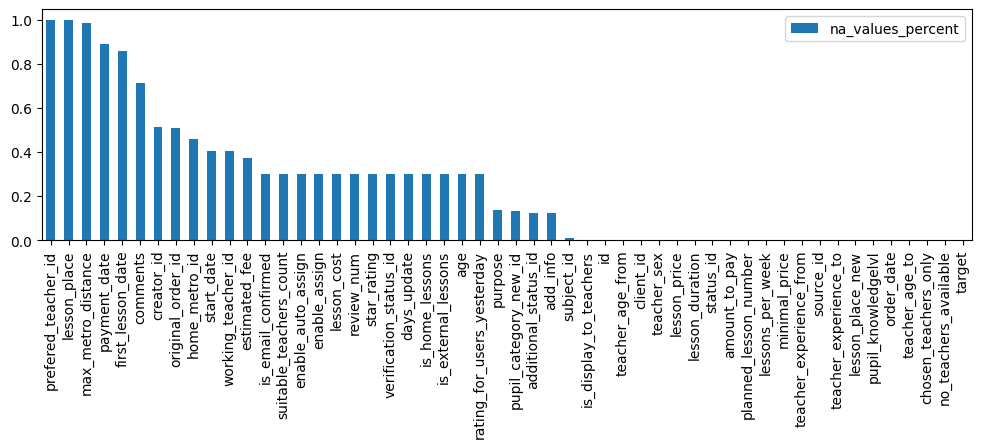

In [14]:
#Вычислим процентное соотношение пропусков 
na_values_percent = (df.isna().sum() / len(df)).to_frame().rename(columns = {0:'na_values_percent'}).sort_values(by = 'na_values_percent', ascending = False)

#Построим график с процентным соотношением пропусков
na_values_percent.plot.bar(figsize = (12,3))
;

Посмотрим так же на числовое представление процентов пропусков в каждом из столбцов.

In [15]:
na_values_percent.transpose()

,prefered_teacher_id,lesson_place,max_metro_distance,payment_date,first_lesson_date,comments,creator_id,original_order_id,home_metro_id,start_date,working_teacher_id,estimated_fee,is_email_confirmed,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,days_update,is_home_lessons,is_external_lessons,age,rating_for_users_yesterday,purpose,pupil_category_new_id,additional_status_id,add_info,subject_id,is_display_to_teachers,id,teacher_age_from,client_id,teacher_sex,lesson_price,lesson_duration,status_id,amount_to_pay,planned_lesson_number,lessons_per_week,minimal_price,teacher_experience_from,source_id,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,order_date,teacher_age_to,chosen_teachers_only,no_teachers_available,target
na_values_percent,0.999997,0.999974,0.988661,0.891215,0.860246,0.713425,0.513563,0.511117,0.460932,0.407956,0.407612,0.373079,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.300523,0.139738,0.133763,0.125421,0.123513,0.008669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Мы видим, что некоторые столбцы практически пусты (процент пропусков близок к 100%).  Однако, на самом деле, мы видим неполную картину, так как при заполнении таблицы, часть пропусков заполнялась нулями. Очевидно, нули в полях вроде planned_lesson_number и так далее означают отсутствие данных. Потому посмотрим на процент пропусков, допустив, что любые нули в таблице означают пропуски. Для этого скопируем датафрейм, заменим все нули на np.nan и вновь посмотрим на процент пропусков.

<b>Безусловно мы понимаем</b>, что приравнивать нули к пропускам некорректно, так как нули могут быть значимыми (например в том же столбце target и в других бинарных признаках), потому мы будем учитывать это и смотреть на каждую колонку отдельно.

<Axes: >

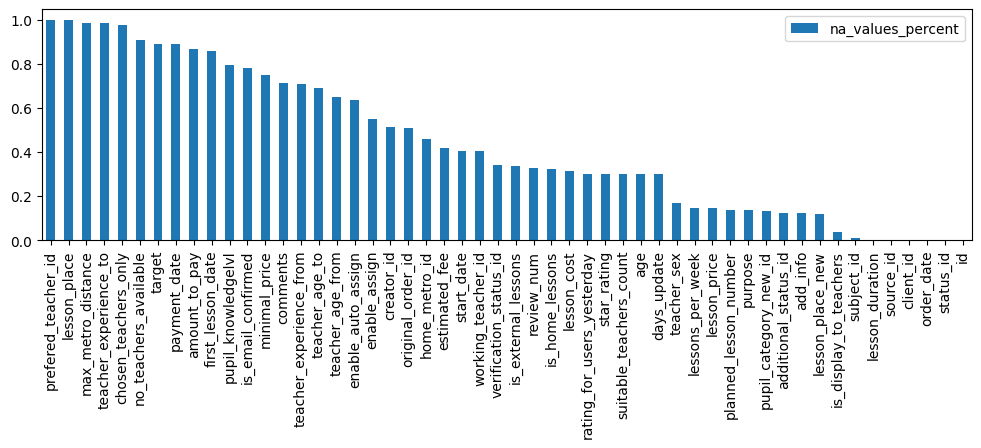

In [16]:

# Создаём временный датасет
df2 = df.copy()
# Заменяем все нули на пропуски (в том числе те нули, которые в текстовом формате)
df2 = df2.replace(0, np.nan)
df2 = df2.replace('0', np.nan)

#Также подсчитываем процентное соотношение пропусков и строим график
na_values_percent = (df2.isna().sum() / len(df)).to_frame().rename(columns = {0:'na_values_percent'}).sort_values(by = 'na_values_percent', ascending = False)
na_values_percent.plot.bar(figsize = (12,3))

In [17]:
#Удаляем временный датасет, чтобы он не грузил память
del df2
na_values_percent.transpose()

,prefered_teacher_id,lesson_place,max_metro_distance,teacher_experience_to,chosen_teachers_only,no_teachers_available,target,payment_date,amount_to_pay,first_lesson_date,pupil_knowledgelvl,is_email_confirmed,minimal_price,comments,teacher_experience_from,teacher_age_to,teacher_age_from,enable_auto_assign,enable_assign,creator_id,original_order_id,home_metro_id,estimated_fee,start_date,working_teacher_id,verification_status_id,is_external_lessons,review_num,is_home_lessons,lesson_cost,rating_for_users_yesterday,star_rating,suitable_teachers_count,age,days_update,teacher_sex,lessons_per_week,lesson_price,planned_lesson_number,purpose,pupil_category_new_id,additional_status_id,add_info,lesson_place_new,is_display_to_teachers,subject_id,lesson_duration,source_id,client_id,order_date,status_id,id
na_values_percent,0.999997,0.999974,0.988664,0.985555,0.977632,0.909142,0.893125,0.891215,0.87099,0.860246,0.794915,0.785021,0.752671,0.713425,0.709347,0.693716,0.6521,0.639229,0.553444,0.513563,0.511117,0.460932,0.42157,0.407956,0.407612,0.342985,0.336739,0.328312,0.32608,0.313365,0.302347,0.300523,0.300523,0.300523,0.300523,0.170916,0.147043,0.146949,0.139777,0.139738,0.133763,0.125421,0.123515,0.119219,0.035858,0.008669,0.002003,0.000442,0.0,0.0,0.0,0.0


#### Вывод, основанный на процентном соотношении пропусков

Когда мы смотрели на пропуски, то большее число пропусков (больше 95%) было у столбцов <b>prefered_teacher_id, lesson_place, max_metro_distance<b>. Когда мы рассматривали также и нулевые значения, то к таким признакам добавились teacher_experience_to и chosen_teachers_only. 
chosen_teachers_only -- бинарный категориальный признак, потому нули здесь значимы. Однако, возникает вопрос о том, возможен ли этот признак при первичном заполнении заявки. Кроме того, данный признак имеет очень сильный дисбаланс. Вышеперечисленные признаки будут удалены из датасета, но позже, пока они нам ещё нужны.





### Анализ выбросов

По сути у нас нет задачи удалить все выбросы, так как они могут быть сами по себе значимы (например, указывать на неаккуратное заполнение заявки, что само по себе может быть признаком), однако мы удалим те данные, которые явно некорректны.


In [18]:
#Выделим числовые признаки
numeric_columns = []

#Выделим те признаки, которые не являются object
for i in df.columns:
    if df[i].dtype != 'object':
        
        numeric_columns.append(i)

Для начала взглянем подробней на lesson_price. Этот признак имеет огромные выбросы. Мы рассмотрим его перед тем, как строить основной график с ящиками с усами, так как с этими выбросами график будет абсолютно бесполезен.

<Axes: >

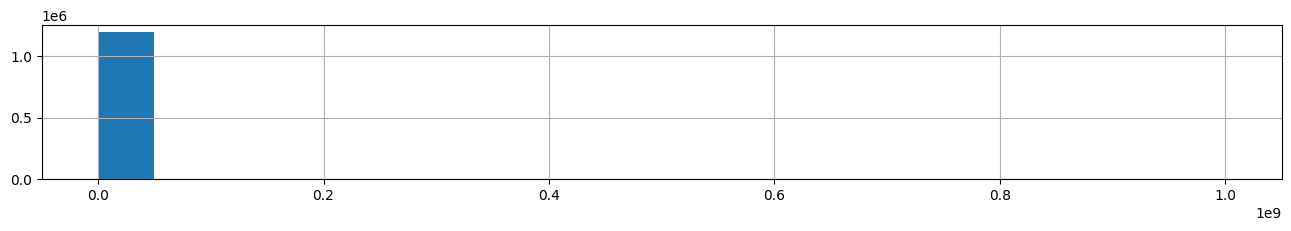

In [19]:
#Убеждаемся, что здесь есть огромные выбросы
df['lesson_price'].hist(bins = 20, figsize = (16, 2))


Мы видим, что здесь присутствуют огромные значения, глянем на них

In [20]:
df.query('lesson_price >= 1000000').sort_values(by = 'lesson_price', ascending = False)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
775985,1862907,2021-11-20 13:20:45.717,2.0,\n​Категория ученика : школьники 7 класса,1000000000,60,None,NaN,"\n​Свободное время : Понедельник-утро,Понедель...",None,NaN,7,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,0,0,None,NaN,8.0,0,15,3,0,0,4,0,18,30,0,0,16,NaN,872053,6.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
835666,1922597,2022-01-17 14:47:58.423,1.0,"\n​Разделы : школьный курс, .вузовский курс \...",20000000,60,None,NaN,"\n​Свободное время : Среда-утро,Четверг-день,С...",None,NaN,7,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,0,1,None,NaN,9.0,0,50000,3,0,0,4,0,30,50,0,0,16,NaN,891766,5.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
94824,2388889,2022-12-26 10:04:21.907,8.0,\n​Разделы : алгебра \n​Цель занятий : люблю м...,10090000,60,None,NaN,"\n​Свободное время : Понедельник-утро,Вторник-...",None,NaN,7,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,0,7,None,NaN,8.0,0,150000,3,0,0,4,0,18,80,0,0,16,NaN,1058704,14.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1117836,2206463,2022-09-19 18:23:30.640,2.0,\n​Цель занятий : Хочу что ты свн позанимался ...,10000000,60,None,258.0,\n​Место проведения занятий : у ученика(Улица ...,None,NaN,7,Тестовая группа : SplitTestB\n?Статус дозаполн...,NaN,0,10,None,NaN,7.0,7,10000000,1,0,0,1,0,18,30,0,0,16,2206462.0,994865,7.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1047017,2135618,2022-08-16 01:46:00.420,25.0,\n​Разделы : иероглифика \n​Дополнения : серти...,7777777,60,None,1766.0,\n​Место проведения занятий : у преподавателя ...,None,NaN,7,Тестовая группа : SplitTestB\n?Статус дозаполн...,NaN,0,10,None,NaN,16.0,7,10,2,0,0,2,0,18,30,0,0,16,NaN,970980,16.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
846502,1933436,2022-01-23 22:26:33.897,8.0,"\n​Разделы : школьный курс, алгебра \n​Дополн...",7500095,60,None,NaN,"\n​Свободное время : Среда-вечер,Суббота-день ...",None,NaN,7,Тестовая группа : SplitTestB\n?Статус дозаполн...,NaN,0,10,None,905307.0,10.0,4,200,2,5,100,4,0,50,80,0,0,16,1922573.0,891753,7.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1191860,3605505,0029-07-18 05:28:02.684,3605505.0,None,3605505,3605505,None,3605505.0,None,0029-07-18 05:28:02.684,3605505.0,3605505,None,3605505.0,"4,450342944189884E-308",3605505,0029-07-18 05:28:02.684,3605505.0,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.0,3605505,3605505.0,3605505.0,"4,450342944189884E-308",0029-07-18 05:28:02.684,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
325999,3342337,0042-01-12 04:26:08.039,3342337.0,None,3342337,3342337,None,3342337.0,None,0042-01-12 04:26:08.039,3342337.0,3342337,None,3342337.0,"8,344239172283769E-308",3342337,0042-01-12 04:26:08.039,3342337.0,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,3342337.0,3342337,3342337.0,3342337.0,"8,344239172283769E-308",0042-01-12 04:26:08.039,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
105390,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,None,3211265.0,None,

Очевидно, эти заявки заполнялись неаккуратно, кроме того, присутствуют странные значения, где все столбйызаполнены числами вроде 3605505.0. Мы удалим эти выбросы, поскольку здесь явно присутствуют "битые" данные, которые помешают дальнейшей работе с данными.

С max_metro_distance подобная ситуация, посмотрим и на этот признак.

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
105390,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,None,3211265.0,None,0042-01-12 05:09:05.007,3211265.0,3211265,None,3211265.0,"8,344264636103745E-308",3211265,0042-01-12 05:09:05.007,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,3211265.0,3211265.0,"8,344264636103745E-308",0042-01-12 05:09:05.007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
325999,3342337,0042-01-12 04:26:08.039,3342337.0,None,3342337,3342337,None,3342337.0,None,0042-01-12 04:26:08.039,3342337.0,3342337,None,3342337.0,"8,344239172283769E-308",3342337,0042-01-12 04:26:08.039,3342337.0,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,3342337.0,3342337,3342337.0,3342337.0,"8,344239172283769E-308",0042-01-12 04:26:08.039,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
724176,2906215,2023-10-23 12:52:47.350,1.0,"Категория ученика: девочка 8 лет, учится в Кан...",800,60,None,NaN,! ВРЕМЯ: МИНУС 7 часов от МСК. Канада\nЖелаем...,2023-10-25 09:55:32.857,123933.0,11,None,NaN,0,10,None,147147.0,NaN,2,0,3,0,0,6,0,25,0,0,0,14,2805163.0,1220609,NaN,5000000.0,2160,None,1,107.0,0.0,0.009346,645.093458,11.196262,4.851271,2.028037,0.0,0.570093,0.448598,1548.032715,43.290693,139.747664,0
1191860,3605505,0029-07-18 05:28:02.684,3605505.0,None,3605505,3605505,None,3605505.0,None,0029-07-18 05:28:02.684,3605505.0,3605505,None,3605505.0,"4,450342944189884E-308",3605505,0029-07-18 05:28:02.684,3605505.0,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.0,3605505,3605505.0,3605505.0,"4,450342944189884E-308",0029-07-18 05:28:02.684,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


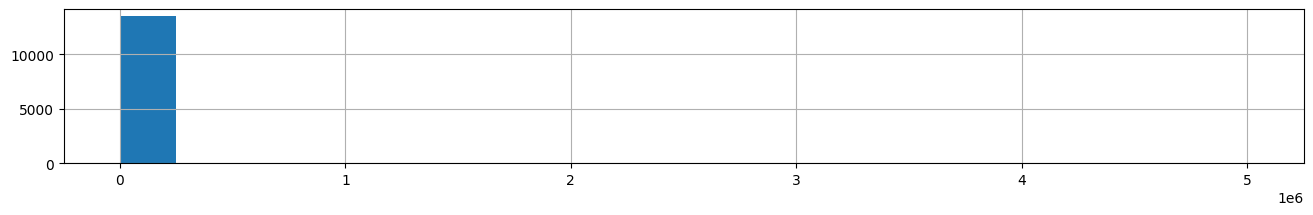

In [21]:
df['max_metro_distance'].hist(bins = 20, figsize = (16, 2))
df.query('max_metro_distance > 10000')

Как видим, тут присутствуют также "битые" данные, особенно чувствительно start_date. Удалим выбросы из этих двух признаков и псмотрим на график.

In [22]:
#Посмотрим есть ли среди выбросов, которые мы собираемся удалить целевые значения
print(df.query('lesson_price > 1000000').target.sum())
print(df.query('max_metro_distance > 10000 ').target.sum())

0
0


Как видим, целевого значения среди тех данных, которые мы хотим удалить, нет.

1190961
1190950


<Axes: >

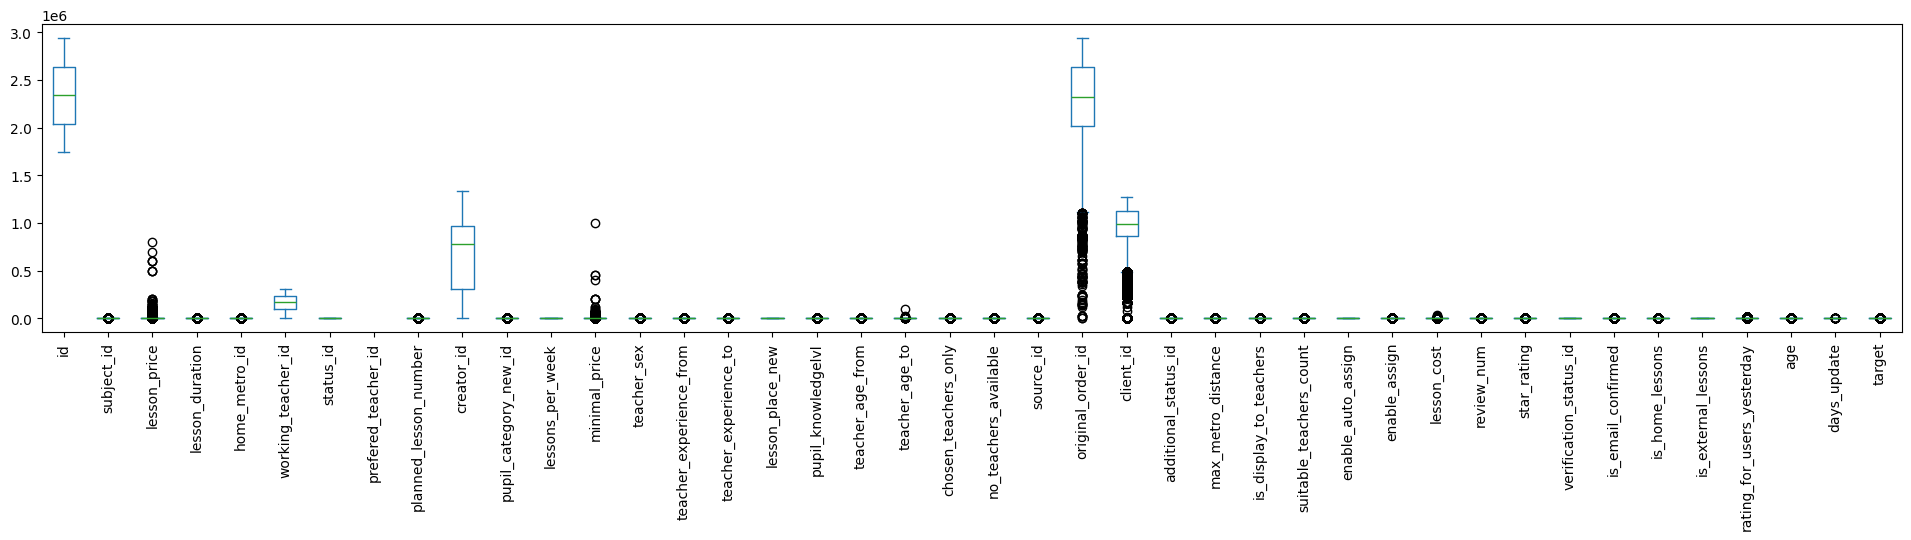

In [23]:
#Запомним текущую длину датасета и выведем её
print(len(df))

#Удалим выбросы, которые мы рассматривали выше
df = df.query('lesson_price < 1000000')
df = df.query('max_metro_distance < 10000 or max_metro_distance.isna() ')
#Выведем новую длину датасета
print(len(df))
#Построим ящики с усами для числовых признаков
df[numeric_columns].plot.box(figsize=(24,4), rot = 90)

Мы удалили не так много значений.
На графике мы наблюдаем явные выбросы в minimal price и lesson_price. Посмотрим на них.

<Axes: >

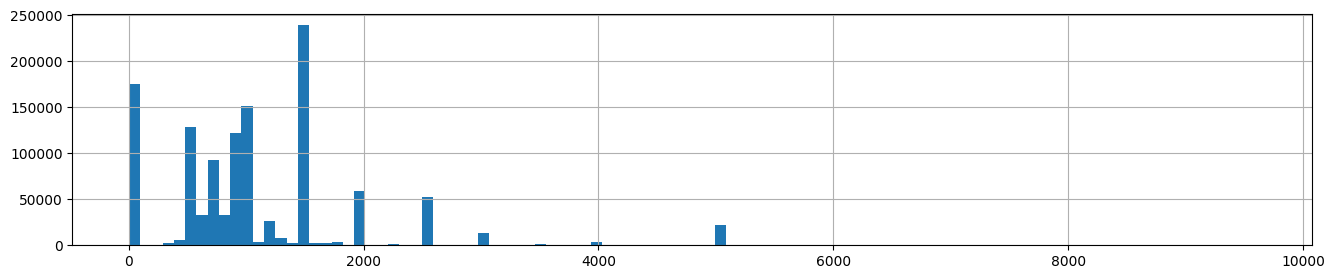

In [24]:
df.query('lesson_price < 10000').lesson_price.hist(figsize = (16,3), bins = 100)

<Axes: >

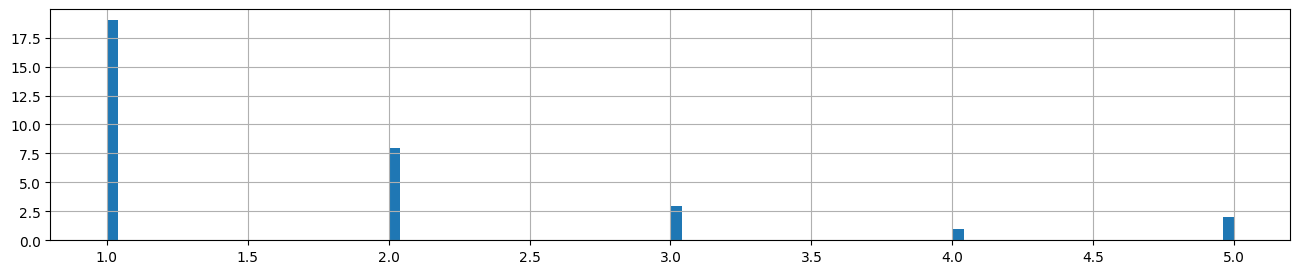

In [25]:
df.query('lesson_price < 10 and lesson_price != 0').lesson_price.hist(figsize = (16,3), bins = 100)

Мы видим, что есть много заявок, где цена примерно 5000, то что выше скорее всего выбросы. Также, мы видим несуразно низкие значения, вроде 1, 2 и т.п. Посмотрим на такие записи подробней.

In [26]:
df.sort_values(by = 'lesson_price', ascending = False).head(3)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
609565,2791603,2023-09-13 13:41:48.490,7.0,Разделы: общий курс.\nКатегория ученика: школ...,800000,0,None,252.0,Район: г. Щёлково.\nМесто проведения занятий: ...,None,NaN,16,None,NaN,0,10,None,606674.0,9.0,5,50000,3,0,0,1,1,0,0,0,1,14,2708857.0,978300,8.0,NaN,None,None,1,12.0,0.0,0.000000,641.666667,1.083333,4.433919,1.750000,0.000000,0.666667,1.000000,646.958313,27.704110,224.833333,0
285902,2547912,2023-03-28 10:22:28.867,9.0,Цель занятий: нужен автор на печатный контент ...,700000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,None,NaN,16,None,NaN,0,10,None,NaN,NaN,3,400000,3,0,0,4,0,0,0,1,0,8,2538732.0,1118851,18.0,NaN,None,None,1,1.0,0.0,0.000000,2000.000000,12.000000,5.000000,3.000000,0.000000,1.000000,1.000000,1576.000000,60.189041,146.000000,0
977221,2064608,2022-05-23 14:59:23.190,8.0,Цель занятий: запись видео-лекций по разделам:...,600000,0,None,NaN,"Запись будет происходить в студии видеозаписи,...",2022-05-24 13:12:51.280,4980.0,16,None,NaN,0,10,None,479212.0,14.0,7,0,3,0,0,3,0,45,0,0,0,14,2062554.0,942781,10.0,NaN,1920000,None,1,24.0,0.0,0.041667,2208.333333,17.958333,4.932943,2.291667,0.041667,0.750000,0.708333,1355.750000,61.173973,179.750000,0


In [27]:
df.query('lesson_price !=0').sort_values(by = 'lesson_price').head(3)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
946693,2033641,2022-04-12 14:17:18.820,3.0,\n​Категория ученика : Студент,1,60,None,34.0,\n​Место проведения занятий : у преподавателя ...,None,NaN,7,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,0,2,None,NaN,14.0,2,0,3,0,0,2,0,30,50,0,0,16,NaN,932063,1.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
75139,2369204,2022-12-12 14:24:57.870,21.0,Дополнения: ЕГЭ.\nКатегория ученика: 11 класс....,1,60,None,1078.0,"Желаемое время для занятий: четверг - 15, 16, ...",None,NaN,16,\n?Статус дозаполнения : начато заполнение кли...,NaN,0,10,None,NaN,2.0,4,0,0,0,0,4,0,18,80,0,0,23,NaN,1050556,5.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1164435,2253068,2022-10-11 19:32:44.670,2.0,Разделы: общий курс.\nКатегория ученика: молод...,1,60,None,983.0,Район: Свердловский район.\nМесто проведения з...,None,NaN,7,\n?Статус дозаполнения : начато заполнение кли...,NaN,0,0,None,47749.0,15.0,1,1,2,0,0,3,2,18,30,0,0,14,2246600.0,1007828,7.0,NaN,1500,None,1,17.0,0.0,0.0,344.117647,0.823529,4.44761,0.764706,0.235294,0.470588,0.764706,180.779419,29.938114,328.647059,0


Сами по себе заявки выглядят нормально. Мы в любом случае удалим lesson_price в будущем, так что сами по себе выбросы не так важны. Посмотрим теперь на mnimal_price

<Axes: >

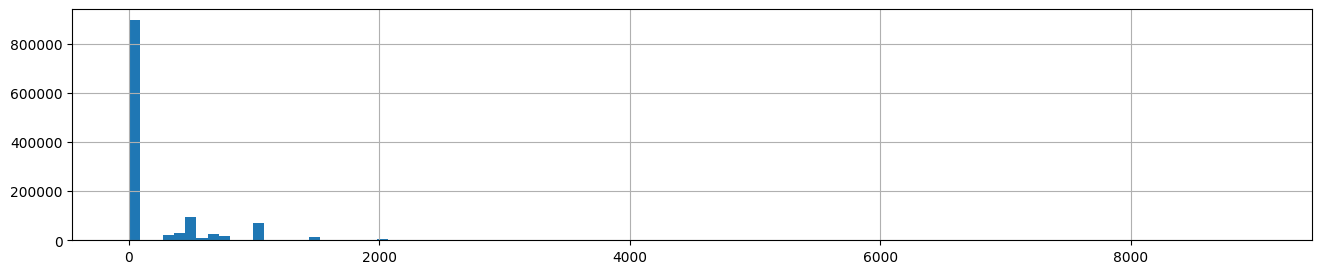

In [28]:
df.query('minimal_price < 10000').minimal_price.hist(figsize = (16,3), bins = 100)

<Axes: >

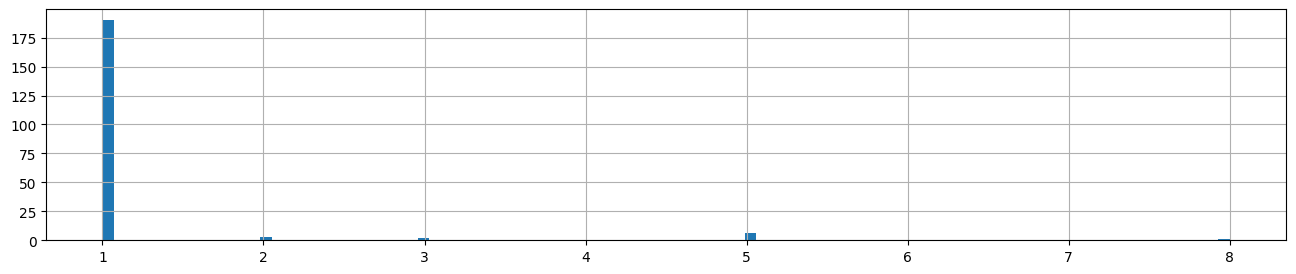

In [29]:
df.query('minimal_price < 10 and minimal_price != 0').minimal_price.hist(figsize = (16,3), bins = 100)

In [30]:
df.sort_values(by = 'minimal_price', ascending = False).head(3)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
937756,2024704,2022-04-04 12:02:19.363,33.0,Разделы: общий курс.\nКатегория ученика: школь...,18,60,None,80.0,Адрес: 3 почтовое отделение ; Время: Подстроюс...,None,NaN,7,\n?Статус дозаполнения : начато заполнение кли...,NaN,0,0,None,NaN,17.0,1,1000000,2,1,0,3,1,50,80,0,0,23,NaN,928719,19.0,NaN,None,None,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
455320,2637358,2023-06-15 12:54:03.517,2.0,"В студию иностранных языков, требуется препода...",60000,0,None,248.0,Район: г. Фрязино.\nМесто проведения занятий: ...,2023-06-15 13:12:28.233,10843.0,16,None,NaN,0,10,None,304610.0,2.0,7,450000,3,0,0,1,1,25,65,0,0,14,2635082.0,1157388,13.0,NaN,168000,None,1,14.0,0.0,0.071429,621.428571,3.142857,4.585938,1.714286,0.0,0.500000,1.0,544.821411,32.188258,253.071429,0
453044,2635082,2023-06-13 17:06:07.403,2.0,"В студию иностранных языков, требуется препода...",60000,0,None,248.0,Район: г. Фрязино.\nМесто проведения занятий: ...,2023-06-15 12:53:57.180,36848.0,16,None,NaN,0,10,None,NaN,2.0,7,450000,3,0,0,1,1,25,65,0,0,23,NaN,1157388,10.0,NaN,192000,None,1,15.0,1.0,0.066667,646.666667,4.733333,4.600260,1.800000,0.0,0.466667,1.0,563.099976,33.637808,244.533333,0


In [31]:
df.query('minimal_price != 0').sort_values(by = 'minimal_price', ascending = True).head(3)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
365125,2437737,2023-01-24 12:03:42.847,1.0,"Мне 49 лет, сдаю ЕГЭ в этом году, чтобы поступ...",3,60,None,NaN,\n​Возраст репетитора : От 30 до 50 лет \n​Доп...,2023-01-24 12:09:22.360,61928.0,6,Тестовая группа : SplitTestB\n?Статус дозаполн...,NaN,0,10,2023-01-28 00:00:00.000,NaN,15.0,0,1,0,10,50,4,0,30,50,0,0,5,NaN,1079585,NaN,NaN,0,None,1,10.0,1.0,0.00,2650.0,44.80,4.919141,2.80,0.00,0.50,0.5,5625.200195,39.219726,126.00,1
122787,1746965,2021-09-03 09:24:14.630,8.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,600,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2021-09-03 10:39:27.213,64342.0,14,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,150,10,2021-09-06 00:00:00.000,NaN,10.0,5,1,3,0,0,4,0,30,80,0,0,16,NaN,834797,21.0,NaN,2100,2021-09-15 13:38:27.443,1,25.0,0.0,0.04,804.0,29.16,4.795469,1.24,0.04,0.64,0.4,996.150024,53.936767,203.12,0
8990,2303044,2022-11-06 18:24:13.110,8.0,"Разделы: школьный курс, алгебра, геометрия.\n...",500,60,None,2663.0,Район: Железнодорожный район.\nМесто проведени...,None,NaN,16,Тестовая группа : SplitTestB\n?Статус дозаполн...,NaN,0,10,None,NaN,8.0,4,1,2,0,0,1,0,18,30,0,1,16,NaN,1027206,8.0,NaN,None,None,1,2.0,1.0,0.00,0.0,0.00,4.300781,0.00,0.00,0.00,1.0,125.000000,20.178082,417.00,0


Здесь мы наблюдаем похожую картину. Эти выбросы сами по себе нам не мешают, потому оставим их.

Мы наблюдаем отсутствие огромных выбросов. Остальные выбросы не трогаем, они пригодятся нам в дальейшем. Теперь посмотрим на status_id и teacher_sex. Аномалии в этих переменных могут означать наличие "битых" данных.

In [32]:
print(df.status_id.unique())
print(df.teacher_sex.unique())

[16  7  6 14 12  8 13 15  1 11  4  9  2  3  5]
[3 0 2 1]


В status_id всё в порядке, в teacher_sex мы наблюдаем четыре значения. Известно, что одно из них означает отсутствие значения, возможно на самом деле это означает два значения, так что не будем трогать.

Теперь нам нужно удалить те признаки, которые мы не будем использовать в обучении модели.

In [33]:
df = df.drop(columns = COLUMNS_TO_DROP)

Глянем на получившийся результат. 

In [34]:
df.head(1)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,no_teachers_available,source_id,original_order_id,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,NaN,0,NaN,NaN,0,0,3,0,0,0,0,0,0,18,2294000.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Промежуточный вывод по анализу выбросов

Мы избавились от экстремальных выбросов, а также выбрали столбцы, с которыми будем работать (в дальнейшем надо будет ещё избавиться от нескольких неинформативных столбцов, но пока они нам нужны). Далее нам необходимо привести к хорошему виду такие данные, как даты и текстовые данные, а также решить проблему с дублирующими заявками.

### Работа с дублирующими заявками

Дублирующие заявки возникают тогда, когда клиент по той или иной причине хочет связаться с несколькими репетиторами. При том, по условию задачи все заявки считаются оплаченными, если оплачена хотя бы одна из них. Мы изменим таргет всех дублирующих заявок на 1, если хотябы одна заявка оплачена. 

Для начала изменим тип original_order_id на int, так же заполним пропуски значениями, равными id (если заказ не дубль, то он оригинал самого себя, что логично). Заодно изменим тип order_date на дату, чтобы можно было работать с ним и по нему также сортировать заявки.

In [35]:
#заполняем пропуски original_order_id значениями id самой заяки.
df.original_order_id = df.original_order_id.fillna(df['id'])
#Меняем типы данных
df.original_order_id = df.original_order_id.astype("int")
df.order_date = df.order_date.astype("datetime64[ns]")

Глянем на original_order_id и сами айдишники.

In [36]:

df[['id', 'original_order_id', 'target']].sort_values(by = 'original_order_id', ascending=False).head(5)


,id,original_order_id,target
741421,2923460,2938030,1
754324,2936366,2937205,0
718343,2900382,2937195,0
754231,2936273,2936924,0
754641,2936683,2936683,0


Проверим, всегда ли в таблие есть заказ с айди, указанным в original_order_id. Возьмём конкретный пример из первой строки в предыдущем выводе для примера.

In [37]:
df.query('id == 2938030')

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,no_teachers_available,source_id,original_order_id,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,target


Мы видим, что есть такие значения original_order_id, которых нет в значениях id. Глянем сколько всего подобных заказов.

In [38]:
#Проверим, сколько всего существует заказов, где айди оригинала не в таблице.
id_unique = df.id.unique()
original_id_not_in_id = df.query('original_order_id not in @id_unique')
print('Количество заказов с отсутвующими оригинальными заказами в таблице:',len(original_id_not_in_id), '\nИз них уникальных оригинальных айдишников:', len(original_id_not_in_id.original_order_id.unique()))

Количество заказов с отсутвующими оригинальными заказами в таблице: 2777 
Из них уникальных оригинальных айдишников: 1489


Относительно размеров датасета, заявок с отсутвующими оригиналами относительно немного. Такие группы заявок по какой-то причине не попали в датасет, а потому, возможно, среди них есть такие, где в группе есть оплаченная, но в нашем датасете её нет, из-за этого данные будут не совсем корректны, так что удалим эти заявки. 

In [39]:
df = df.query('original_order_id in @id_unique')
print('Мы удалили в общей сложности ', original_df_len - len(df), ' заявок')


Мы удалили в общей сложности  3688  заявок


Теперь проставим пометим все заявки в группе как оплаченные если в группе есть хотя бы одна оплаченная заявка.

In [40]:
df['target'] = df.groupby('original_order_id')['target'].transform('max')

Далее мы создадим искуственный признак. Рассмотрим каждую заявку в каждой группе и укажем, сколько в этой группе было заявок с более ранней датой. 

In [41]:
#Для начала сгруппируем заявки по дате создания
df = df.sort_values(by = 'order_date')
#Теперь по оригинальному заказу. Порядок дат внутри групп сохранится.
df = df.sort_values(by = 'original_order_id')
#Заново назначим индексы нашим данным
df = df.reset_index(drop = True)

#Инициализируем счётчик
counter = 0
#Инициализируем переменную, которая будет помнить id оригинальной заявки
original_order_id_ = 0
#Инициализируем новый признак
df['dup_count'] = 0

#Проходим в цикле по всему датасету
for i in tqdm(range(len(df))):
    
    #Пока запомненный оригинальный айди равен оригинальному айди текущей строки, будем увеличивать счётчик и записывать в наш новый признак
    if original_order_id_ == df.iloc[i]['original_order_id']:
        counter += 1
        df.at[i, 'dup_count'] = counter
        
    #Если оригинальный айди меняется, сбрасываем счётчик и перезаписываем переменную с оригинальным айди
    else:

        original_order_id_ = df.iloc[i]['original_order_id']
        counter = 0 
        df.at[i, 'dup_count'] = counter

#Посмотрим на результат
df[['order_date', 'original_order_id', 'dup_count']].head(10)

  0%|          | 0/1188173 [00:00<?, ?it/s]

,order_date,original_order_id,dup_count
0,2021-09-01 00:12:16.713,1742636,0
1,2021-09-01 11:43:12.987,1742636,1
2,2021-09-01 08:45:16.610,1742636,2
3,2021-09-01 08:30:54.387,1742636,3
4,2021-09-01 08:29:44.340,1742636,4
5,2021-09-01 08:28:55.420,1742636,5
6,2021-09-01 08:27:53.487,1742636,6
7,2021-09-01 08:22:36.770,1742636,7
8,2021-09-01 08:11:01.337,1742636,8
9,2021-09-01 07:38:19.157,1742636,9


Мы успешно разметили дублирующие заявки, а также пронумеровали заявки в каждом конкретном кластере дублирующих заявок. 

### Синтез признаков и работа с датами

Для начала синтезируем ещё несколько признаков. Для начала используем количество признаков в строке как признак.

In [42]:
df['isna'] = df.isnull().sum (axis= 1 )

Теперь мы рассмотрим несколько категориальных признаков, имеющих небольшое количество значений. Это будут  'teacher_sex', 'no_teachers_available', 'is_display_to_teachers'. Мы переберём все возможные попарные сочетания значений этих признаков и синтезируем на основе этих сочетаний новые признаки. Т.е. например получится признак такого вида: teacher_sex = 0 и no_teachers_available = 0. Если оба эти признака равны нулю, то в нашем новом признаке будет единица т.е. условие выполняется, в противном случае ноль, и так для остальных сочетаний.


In [43]:
#Инициализируем переменную со списком признаков, для которых рассмотрим попарные сочетнаия.
small_cat = ['teacher_sex', 'no_teachers_available', 'is_display_to_teachers']

In [44]:
#Перебираем все признаки для первого из нашей пары кроме последнего. 
for i in tqdm(range(len(small_cat) - 1)):
    #Перебираем все вторые признаки (начиная со следующего после первого)
    for i2 in range(i+1, len(small_cat)):
        #Перебираем уникальные значения первого признака
        for i3 in df[small_cat[i]].unique():
            #Перебираем уникальные значения для второго признака 
            for i4 in df[small_cat[i2]].unique():
                #Генерируем имя нового признака
                new_column_name = small_cat[i] + '_' + str(i3) +'__' +small_cat[i2] + '_' + str(i4)
                #Инициализируем сам признак
                df[new_column_name] = 0
                #Значение нового признака задаётся условием
                df[new_column_name] = (df[small_cat[i]] == i3).astype('int') * (df[small_cat[i2]] == i4).astype('int')
                df[new_column_name]  = df[new_column_name].astype('int')
                #Удаляем новый признак если все его значения оказываются нулм (например, в датафрейме нет нужных сочетаний)
                if len(df[new_column_name].unique()) < 2:
                    print(new_column_name, df[new_column_name].unique())
                    df = df.drop(columns = new_column_name)
    

  0%|          | 0/2 [00:00<?, ?it/s]

Таким образом мы создали новые признаки, которые зависят от значения двух категориальных переменных. Мы взяли небольшое число категориальных переменных, так как иначе мы бы синтезировали огромное число признаков и модель не справилась бы с таким объёмом данных.

### Работа с датами

Осталось извлечь из дат полезные признаки, заодно проанализируем их. Мы не будем извлекать год, так как по сути модель не сможет использовать этот признак, ведь года никогда не повторяются. 

In [45]:
#Создаём новые признаки, которые мы извлекаем из дат создания заявки
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['hour'] = df['order_date'].dt.hour
df['weekday'] = df['order_date'].dt.weekday

Проанализируем получившиеся признаки. Для этого напишем функцию, которая будет показывать абсолютное и относительное количество оплаченных заявок для каждого значения признаков, основанных на дате.

In [46]:
def feature_studing(
        column_name, #Название исследуемого столбца
        relative = True, #Смотрим ли мы на абсолютное или относительное число оплаченных заявок?
        data_frame = df, #Название исследуемого датафрейма
        set_figsize = (12,3)): #Размер графика
    if not relative:
        data_frame.groupby(column_name)['id'].count().plot.bar(rot = 0, figsize = set_figsize)
    else:
        rel_bar = df.groupby(column_name).agg({'id': 'count', 'target':'sum'})
        rel_bar['rel'] = rel_bar['target'] / rel_bar['id']
        rel_bar['rel'].plot.bar(rot = 0, figsize = set_figsize, color = 'orange')



Посмотрим на количество заявок по месяцам\дням\часам, а так же на процент оплаченных заявок.

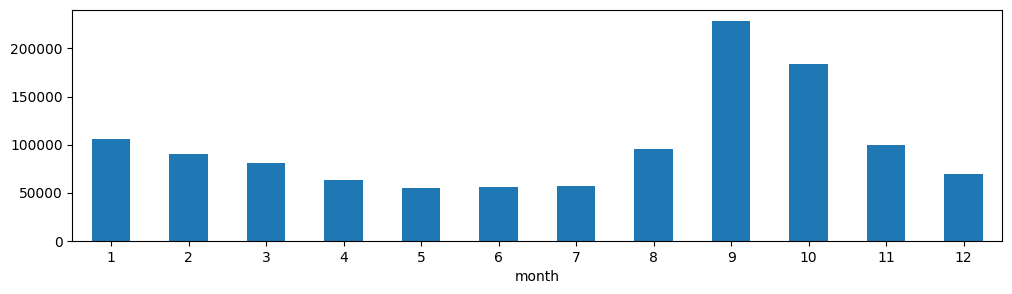

In [47]:
feature_studing('month', relative = False)

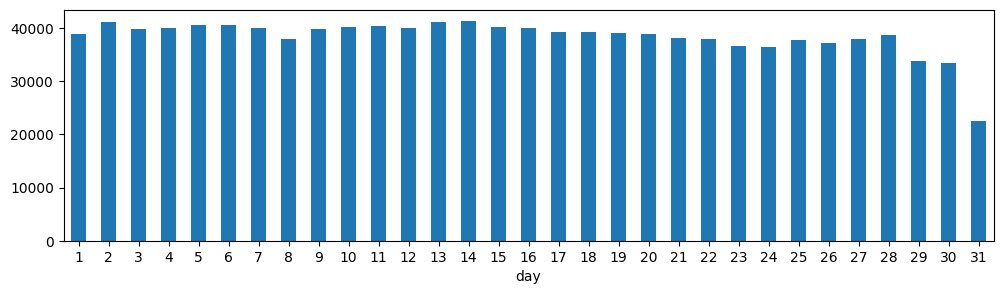

In [48]:
feature_studing('day', relative = False)

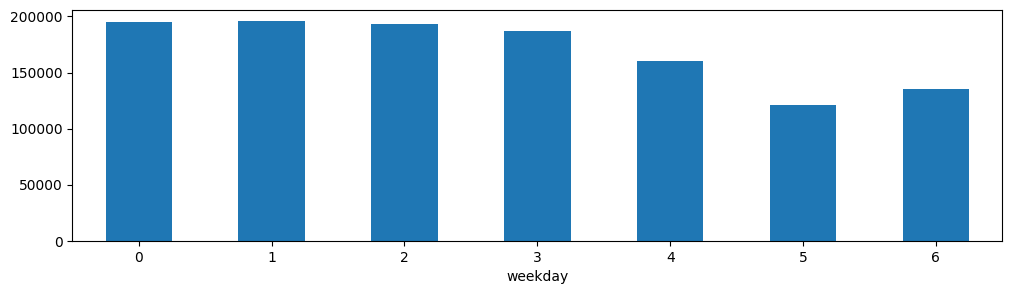

In [49]:
feature_studing('weekday', relative = False)

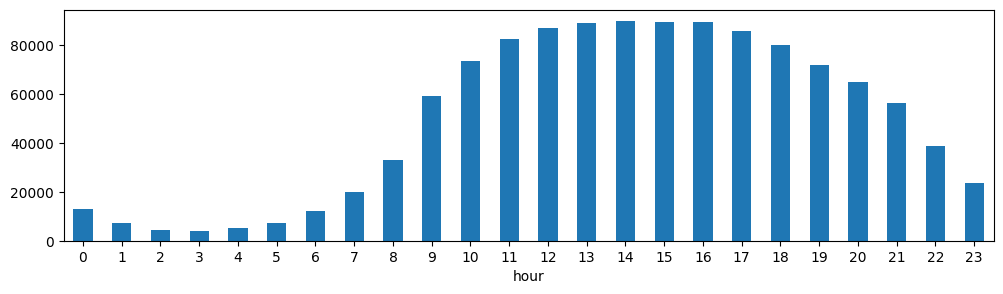

In [50]:
feature_studing('hour', relative = False)

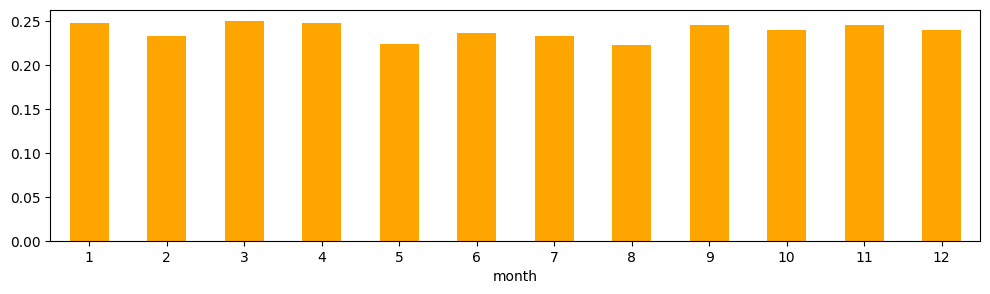

In [51]:
feature_studing('month')

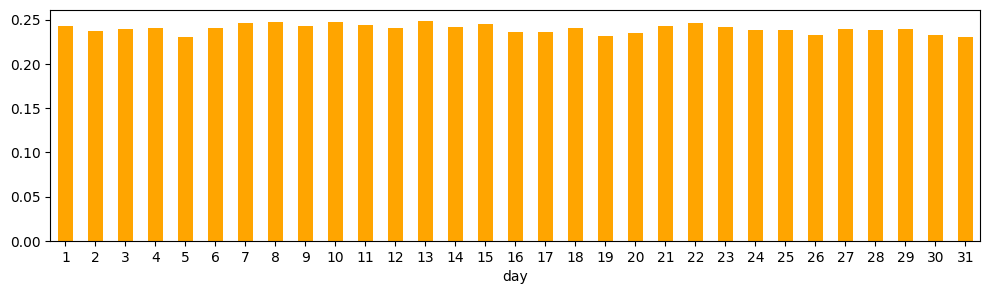

In [52]:
feature_studing('day')

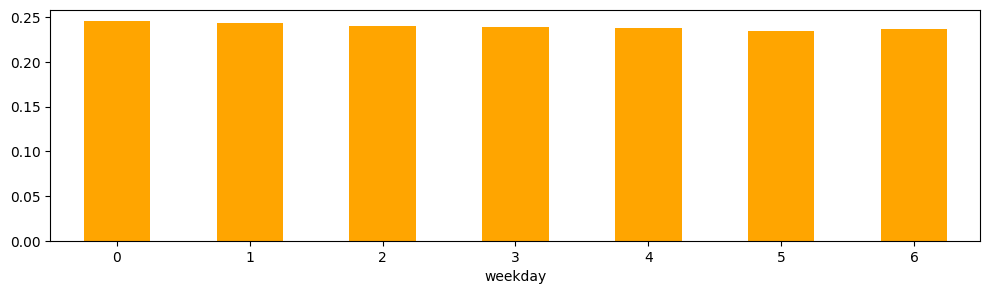

In [53]:
feature_studing('weekday')

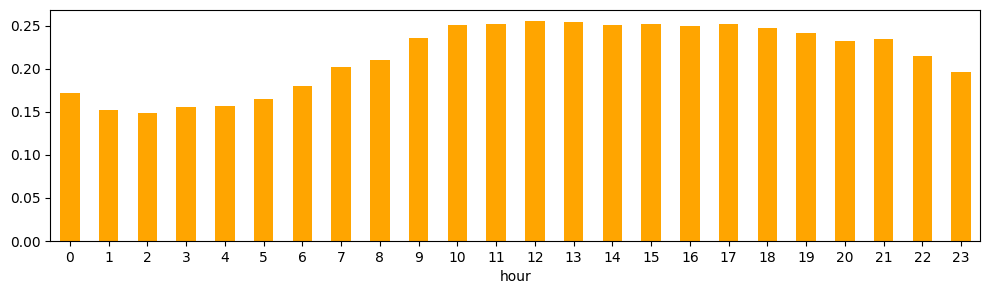

In [54]:
feature_studing('hour')

Мы видим, что количество заявок зависит от месяца, дня недели и часа (от дня месяца зависит слабее, в конце месяцев заявок меньше, но тут стоит учитывать, что месяцы имеют разную длину), для целевой переменной важнее всего час создания заявки, остальные параметры не имеют прямого влияния (однако эти признаки могут быть важны для нелинейной модели, которую мы и будем использовать).

### Вывод

Мы создали новые признаки и извлекли полезную информацию из даты создания заявки. Было принято решение не анализировать подобным образом остальные признаки по следующим причинам:
- Во-первых, это бессмыленно в целом, так как в основном на целевое значение признаки влияют нелинейно, потому подобный анализ не может точно указать влияние того или иного признака.
- Во-вторых, даже без синтетических признаков, их огромное количество и при анализе каждого признака вручную, проект был бы загружен колоссальным количеством графиков.
- В-третьих, мы будем проводить анализ некоторых признаков автоматически, для создания новых синтетических признаков. 

### Работа с текстом

Из текстовых признаков мы будем использовать только purpose и попытаемся вытащить из него полезные признаки. Текстовый признак не самый важный, кроме того по техническим причинам заказчику не нужно, чтобы мы использовали сложную модель вроде Sentence Transformers, потому не будем слишком углубляться в текст.

Уже на этом этапе пора наконец заполнить пропуски. Будем использовать минус единицы

In [55]:
df = df.fillna(-1)

Первый синтетический признак, который мы можем извлечь - длина текста.

In [56]:
df['len_purpose'] = df['purpose'].str.len()

Далее мы используем кластеризацию тексты методом KMean. Для начала нам надо векторизовать текст, а затем получить кластеры, сами векторы мы не будем использовать в качестве признаков, так как это нагрузит модель. Но для начала нам надо отделить обучающую и тестовую части датасета, так как при обучения веткоризатора и кластеризаора может произойти утечка данных.

In [57]:
X = df.drop(columns = 'target')
y = df['target']
#Также необходимо поменять значения, которые мы использовали для маркировки пропусков, иначе возникает ошибка.
X.purpose = X.purpose.apply(lambda x: 'nan' if x == -1 else x)
#Делим датасет.
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Теоретически, для лучших результатов можно было бы предобработать текст, но это не самая важная фича и было решено потратить время на более важные признаки и способы улучшения модели, кроме того, кластеризация и так дала некоторый (не очень большой) импакт качества модели.

In [58]:
#Обучаем векторизатор
vectorizer_purpose = TfidfVectorizer()
vectorizer_purpose.fit(X_train_text['purpose'])
#Создаём матрицы из векторов
tfidf_matrix_purpose_train = vectorizer_purpose.transform(X_train_text['purpose'])
tfidf_matrix_purpose_test = vectorizer_purpose.transform(X_test_text['purpose'])

#Количество кластеров подбиралось опытным путём. Учитывая размер датасета, перебирать большое количество значений было бы очень долго.
num_clusters =  8
#Обучаем кластеризатор
kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=1, max_iter=10, n_init=2).fit(tfidf_matrix_purpose_train)

Initialization complete
Iteration 0, inertia 978500.0450070939.
Iteration 1, inertia 613687.0810283388.
Iteration 2, inertia 599913.447963772.
Iteration 3, inertia 591352.9587642325.
Iteration 4, inertia 582145.9556206717.
Iteration 5, inertia 578178.6630640359.
Iteration 6, inertia 576730.8873046394.
Iteration 7, inertia 575443.2098763952.
Iteration 8, inertia 574898.2559013929.
Iteration 9, inertia 574878.2833192815.
Initialization complete
Iteration 0, inertia 978423.816826638.
Iteration 1, inertia 612237.0867483311.
Iteration 2, inertia 596646.7114202498.
Iteration 3, inertia 582542.1936653075.
Iteration 4, inertia 565095.1406435465.
Iteration 5, inertia 558999.0496128646.
Iteration 6, inertia 557270.606737246.
Iteration 7, inertia 555545.4159431783.
Iteration 8, inertia 554028.1550369165.
Iteration 9, inertia 553954.4324599842.


In [59]:
#Присваеиваем кластера обучающему и тестовому датасетам (но сами векторизаторы и кластеризаторы мы обучили на тренировочном, так что избежали утечки данных)
X_train_text['purpose_cluster'] = kmeans.predict(tfidf_matrix_purpose_train)
X_test_text['purpose_cluster'] = kmeans.predict(tfidf_matrix_purpose_test)

#### Вывод

Мы извлекли данные из текстового признака


## Обучение модели

Теперь нам нужно обучить и протестировать саму модель. Для этого мы пройдём следующие шаги:
- Синтезируем ещё несколько признаков, которые требуют готового разделения на обучающую и тестовую выборки (подобно работе с текстом)
- Подберём лучшие параметры для модели
- Проведём окончательный отбор признаков
- Обучим окончательную модель


В ходе работы над проектом было решено отказаться от всех моделей кроме cat_boost. Остальные модели показывали худший результат, кроме того, некоторые этапы из описанных выше требуют значительных выичислений, при том их было бы необходимо проводить для каждой модели отдельно, потому ради экономии времени и вычислительных ресурсов было решено в финальном проекте оставить только Cat_Boost

Для начала сделаем небольшие приготовления

In [60]:
#Напишем небольшую функцию, которая удалит из датасета те столбцы, которые не будут использоваться при обучении модели.

def final_prepare(data_frame = df):
    data_frame = data_frame.drop(columns = ['id', 'order_date', 'original_order_id', 'purpose'])
    return data_frame
    
#Инициализируем переменную для дальнейших предсказаний
pred = []

In [61]:
#Напишем функцию, которая будет выводить метрики модели
def scoring(true_values, predictions):
    print('f1', f1_score(y_test, pred))
    print('accuracy', accuracy_score(y_test, pred))
    print('recall_score', recall_score(y_test, pred))
    print('precision_score', precision_score(y_test, pred))
    print('roc_auc_score', roc_auc_score(y_test, pred))

In [62]:
#Подготовим наш датасет
X_train = final_prepare(X_train_text)
X_test = final_prepare(X_test_text)

#### Синтез дополнительных признаков

Один из признаков, которые мы будем синтезировать основан на выбросах (мы удалили только самые критичные выбросы). Мы напишем функцию, которая будет автоматически определять, является ли то или иное значения в данных выбросом или нет, а затем для каждой строки считать общее количество выбросов (как ни странно, этот признак действительно немного улучшил модель). 

Для этого мы будем использовать Фильтр Хэмпеля, который возвращает 1 для всех значений, у которых разница с медианой больше, чем три медианных абсолютных отклонения. Мы будем считать медиану, и соответственно определять, является ли значение выбросом, основываясь только на обучающей выборке, то есть, выбросом будет считаться то, что обучающая выборка "считает" выбросом, так как если мы будем использовать и тестовые данные, значения могут поменяться, а мы по идее не знаем тестовых данных.

In [63]:
#Инициализируем список медианных абсолютных отклонений
median_abs_deviation_list = []
#Инициализируем список признаков, которые мы будем исследовать на выбросы.
num_cols = []
#Инициализируем список медиан для каждого признака
median_list = []

#Автоматичски определим признаки, с которыми мы будем работать
for i in X_train.columns:
    if len(X_train[i].unique()) > 100:
        num_cols.append(i)

#Уберём из них те, которые имеют много уникальных значений, но не подходят нам
num_cols.remove('home_metro_id')
num_cols.remove('creator_id')


#Теперь посчитаем медианы и средние медианные отклонения для исследуемых признаков
for i in num_cols:
    vals = X_train[i]
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()

    median_list.append(vals.median())
    median_abs_deviation_list.append(median_abs_deviation)



Мы сохранили значения для медиан и медианных отклонений для наших признаков на тренировочной выборке. Позже мы будем подавать их в функцию, которую и будем использовать для определения выбросов.

In [64]:
#Напишем функцию, которая будет определять выбросы для каждого столбца. 
def hampel(
        vals_orig, #Столбец, который мы изучаем
        median_abs_deviation, #среднее медианное отклонение, которое мы выдадим функции из списка
        median_ #сама медиана
        ):
    
    vals = vals_orig.copy()
    #Считаем разницу между реальным значением и средним медианным отклонением
    difference = np.abs(median_-vals)    
    #Определяем порог, при котором будем считать, что данное значение является признаком
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    norm_idx = difference <= threshold
    #Присваиваем единицы выбросам и нули нормальным данным
    vals[norm_idx] = 0
    vals[outlier_idx] = 1

    #В качестве результата возвращаем Series
    return(vals)

Теперь применем функцию к тренировочному и тестовому датасетам соответственно

In [65]:
#Инициализируем признак для обучающей и тестовой выборок
X_train['ejection'] = 0
X_test['ejection'] = 0

#Перебираем наши столбцы
for i in tqdm(range(len(num_cols))):
#Инициализируем временную колонку с результатами функции. Это нужно, чтобы прибавлять её к нашей колонке с новым признаком. По ходу цикла временная колока будет меняться и эти изменения прибавляться к нашей
    X_train['temporal_column'] = hampel(X_train[num_cols[i]], median_abs_deviation_list[i],median_list[i])
    X_train['ejection'] = X_train[['ejection', 'temporal_column']].sum(axis=1)

    X_test['temporal_column'] = hampel(X_test[num_cols[i]], median_abs_deviation_list[i],median_list[i])
    X_test['ejection'] = X_test[['ejection', 'temporal_column']].sum(axis=1)

#Удаляем временные колонки
X_train = X_train.drop(columns = 'temporal_column')
X_test = X_test.drop(columns = 'temporal_column')

  0%|          | 0/17 [00:00<?, ?it/s]

Теперь создадим ещё один признак. По сути, этот признак - один из способов кодировки категориальных переменных. Мы поступим таким образом - будем перебирать уникальные значений категориальных переменных для тестовой выборки и запоминим среднее значение целевой переменной для каждого уникального значения каждой категориальной переменной на обучающей выборке. ТЕстовая выорка не будет задействована. Мы отберём те категории, в которых немного значений и они постоянны (т.е. есть количество их значений ограничено), но также мы не будем задействовать бинарные категории, так как это бессмысленно.

In [66]:
#Определяем те признаки, которые мы будем использовать, исключая из них бинарные признаки
cat_columns = []
for i in X_train.columns:
    if 2 < len(X_train[i].unique()) <= 11:
        cat_columns.append(i)

Теперь создадим словарь, с помощью которого создадим наши признаки

In [67]:
#Для начала создаём временный датасет, в котором будут и признаки и целевые переменные, но только для обучающей выборки.
Train = X_train.copy()
Train['target'] = y_train

#Инициализируем словарь словарей, в котором ключами будут служить названия признаков, а значениями словари, в которых в свою очередь ключами будут служить уникальные значения признаков
#А значениями - средний показатель целевого признака для данного значения данного признака
dict_of_dict = {}
#Проходим циклом по нашим признакам
for iterator in tqdm(range(len(cat_columns))):
    i = cat_columns[iterator]
    #Инициализируем словарь, который будет значением словаря словарей
    dict = {}
    #Проходим циклом по уникальным значениям нашего признака
    for e in Train[i].unique():
        query_str = i + '==' + str(e)
        #Считаем среднее целевой переменной только по тем строкам данных, которые удовлетворяют условию, которое заключается в том, что соотвествующий признак равен соответсвующему значению. 
        dict[e] =  Train.query(query_str)['target'].mean()
    #Добавляем получившийся словарь в словарь словарей
    dict_of_dict[i] = dict

#Посмотрим на результат
dict_of_dict

  0%|          | 0/8 [00:00<?, ?it/s]

{'lesson_duration': {60: 0.23782256765730447,
  90: 0.36622409485081575,
  45: 0.19684790176593456,
  0: 0.1407328730748805,
  120: 0.31224952082244295,
  135: 0.19736842105263158},
 'planned_lesson_number': {10: 0.25931447395313606,
  0: 0.1547001663442649,
  2: 0.12191174884022009,
  7: 0.22097158570119158,
  1: 0.07838299487568799},
 'lessons_per_week': {5: 0.23031288029206431,
  4: 0.2815949550162707,
  0: 0.15478371646961153,
  6: 0.21944172815361365,
  3: 0.23766355544655865,
  7: 0.2426379095810867,
  2: 0.29674886214576857,
  1: 0.31421205285207865},
 'teacher_sex': {2: 0.25054836131095126,
  3: 0.24551361492061102,
  0: 0.19698709016016058,
  1: 0.2790362101824122},
 'lesson_place_new': {1: 0.21313000319117878,
  4: 0.32610506345221707,
  0: 0.14729044903148342,
  6: 0.23142631039940414,
  2: 0.143977297180977,
  7: 0.24227437289888804,
  3: 0.22020265003897116,
  5: 0.2915714848365498},
 'pupil_knowledgelvl': {0: 0.23580236135692045,
  3: 0.2832053872053872,
  1: 0.2171937691

Как видим, у нас получилось создать нужный словарь. Теперь нужно создать новые признаки. Это будут новые колонки с соответствующими значениями.

In [68]:
# Проходим циклу по нашим признакам
for i in tqdm(range(len(cat_columns))):
    #Генерируем название нового столбца
    column_name = cat_columns[i]
    new_column_name = column_name + '__mean_target'
    #Вытаскиваем нужный словарь из словаря словарей для каждого признака
    replace_dict = dict_of_dict[column_name]
    #Создаём новые столбцы, которые содержат полученные значения для обучающей и тестовой выборок. Но так как мы считали значения только на обучающей, утечки данных нет.
    X_train[new_column_name] = X_train[column_name].replace(replace_dict)
    X_test[new_column_name] = X_test[column_name].replace(replace_dict)

#### Ниже под коммнтариями находятся строки кода, которые должны были избавиться от оригинальных категориальных столбцов. Однако, практика показала, что имеет смысл оставлять как старые, так и новые столбцы.
#X_train = X_train.drop(columns = cat_columns)
#X_test = X_test.drop(columns = cat_columns)

X_train.head(5)

  0%|          | 0/8 [00:00<?, ?it/s]

,subject_id,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,no_teachers_available,source_id,is_display_to_teachers,suitable_teachers_count,enable_auto_assign,enable_assign,lesson_cost,review_num,star_rating,verification_status_id,is_email_confirmed,is_home_lessons,is_external_lessons,rating_for_users_yesterday,age,days_update,dup_count,isna,teacher_sex_3__no_teachers_available_0,teacher_sex_3__no_teachers_available_1,teacher_sex_0__no_teachers_available_0,teacher_sex_0__no_teachers_available_1,teacher_sex_1__no_teachers_available_0,teacher_sex_1__no_teachers_available_1,teacher_sex_2__no_teachers_available_0,teacher_sex_2__no_teachers_available_1,teacher_sex_3__is_display_to_teachers_1,teacher_sex_3__is_display_to_teachers_0,teacher_sex_0__is_display_to_teachers_1,teacher_sex_0__is_display_to_teachers_0,teacher_sex_1__is_display_to_teachers_1,teacher_sex_1__is_display_to_teachers_0,teacher_sex_2__is_display_to_teachers_1,teacher_sex_2__is_display_to_teachers_0,no_teachers_available_0__is_display_to_teachers_1,no_teachers_available_0__is_display_to_teachers_0,no_teachers_available_1__is_display_to_teachers_1,no_teachers_available_1__is_display_to_teachers_0,month,day,hour,weekday,len_purpose,purpose_cluster,ejection,lesson_duration__mean_target,planned_lesson_number__mean_target,lessons_per_week__mean_target,teacher_sex__mean_target,lesson_place_new__mean_target,pupil_knowledgelvl__mean_target,weekday__mean_target,purpose_cluster__mean_target
1105782,19.0,2500,60,253.0,10,-1.0,4.0,5,0,2,0,1,0,0,0,0,23,0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6,14,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,10,2,8,0,89.0,6,7.0,0.237823,0.259314,0.230313,0.250548,0.213130,0.235802,0.245416,0.232584
445448,18.0,700,60,1481.0,10,255224.0,5.0,4,0,2,0,1,0,0,0,0,4,1,11.0,0.181818,0.090909,368.181818,2.363636,4.345881,0.272727,0.0,0.545455,1.000000,360.340912,33.035118,263.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,9,12,12,0,115.0,3,0.0,0.237823,0.259314,0.281595,0.250548,0.213130,0.235802,0.245416,0.255339
386181,2.0,1500,60,-1.0,10,-1.0,10.0,5,1000,3,0,4,0,0,0,0,22,1,3.0,0.000000,0.333333,1066.666667,17.333333,4.966146,2.000000,0.0,0.333333,0.333333,2401.666748,39.621918,128.333333,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,8,11,17,3,88.0,4,4.0,0.237823,0.259314,0.230313,0.245514,0.326105,0.235802,0.238690,0.322078
572698,36.0,0,60,-1.0,0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,16,1,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2,17,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,11,13,19,6,NaN,1,7.0,0.237823,0.154700,0.154784,0.196987,0.147290,0.235802,0.236529,0.154818
414164,2.0,1500,60,-1.0,10,-1.0,15.0,6,0,0,0,4,3,0,0,0,23,1,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,15,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,8,31,17,2,67.0,2,7.0,0.237823,0.259314,0.219442,0.196987,0.326105,0.283205,0.239850,0.261881


#### Проблемма дисбаланса классов

Наши данные являются крайне несбалансированными. Это было видно ещё на этапе анализа пропусков. Лучшим решением оказался метод upsampling тренировочной выборки, естественно, тестовую мы не трогаем. НА самом деле, более того, лучшим оказалось даже создать дисбаланс классов, но в другую сторону.

In [69]:
resampled_train = X_train.merge(y_train, left_index = True, right_index=True)
upsampled_train = resampled_train[resampled_train["target"] == 1]
upsampled_train = resample(upsampled_train,
             replace=True,
             n_samples=len(resampled_train[resampled_train["target"] == 0])*OVERSAMPLING, #Здесь мы как раз и добавляем искуственный дисбаланс
             random_state=42)


resampled_train = pd.concat([upsampled_train,  resampled_train[resampled_train["target"] == 0]])
del upsampled_train
X_train = resampled_train.drop(columns = 'target')
y_train = resampled_train['target']


#### Подбор параметров модели

Для начала нам нужно найти лучшие гиперпараметры для нашей модели. Это не будет конечным решением, но начать лучше именно с этого.

In [70]:
#Инициализируем модель
model = CatBoostClassifier()

#Инициализируем параметры для GridSearchCV
parameters = {'depth'         : [ 8, 10],
                 'learning_rate' : [0.3, 0.5],
                  'iterations'    : [1000],
                  'silent': [True],
                  'task_type':["GPU"],
                  'devices':['0:1'],
                  'random_seed':[42],
                  'grow_policy':['SymmetricTree', 'Depthwise', 'Lossguide']
                  
                 }
#Ищем лучшие гиперпараметры для обучающей выборки
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, verbose = 3, scoring='roc_auc')
Grid_CBC.fit(X_train, y_train, plot=False)

#Запоминаем параметры модели. Мы не будем использовать именно эту модель, так что нам важны именно параметры.
params = Grid_CBC.best_params_

#Выводим результаты
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END depth=8, devices=0:1, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.3, random_seed=42, silent=True, task_type=GPU;, score=0.836 total time=  53.5s
[CV 2/2] END depth=8, devices=0:1, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.3, random_seed=42, silent=True, task_type=GPU;, score=0.836 total time=  51.5s
[CV 1/2] END depth=8, devices=0:1, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.5, random_seed=42, silent=True, task_type=GPU;, score=0.851 total time=  52.9s
[CV 2/2] END depth=8, devices=0:1, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.5, random_seed=42, silent=True, task_type=GPU;, score=0.851 total time=  52.0s
[CV 1/2] END depth=8, devices=0:1, grow_policy=Depthwise, iterations=1000, learning_rate=0.3, random_seed=42, silent=True, task_type=GPU;, score=0.935 total time= 1.1min
[CV 2/2] END depth=8, devices=0:1, grow_policy=Depthwise, iterations=1000

#### Финальный отбор признаков

Чтобы улучшить показатели модели, мы отберём наилучшее сочетание признаков для модели, т.е. отбросим некоторые признаки и таким образом улучшим показатели модели. Для этого мы будем заново обучать модель, но используя при этом не все столбцы, а только некоторые из них и смотреть на лучшие показатели. Есть несколько стратегий того, как определить какие именно сочетаия признаков мы будем проверять:
- Самая лучшая - перебрать все множества подмножеств признаков. Но это годится только для относительно небольших датасетов с относительно небольшим числом признаков, так как даже для десяти признаков получается уже порядка 1024 обучений модели и это количество растёт в геометрической прогрессии, так что это не наш случай.
- Более грубая стратегия - пытаться убрать сначала один признак, выбрать самый лучший вариант, затем убрать уже этот признак и перебирать все оставшиеся и т.п., пока показатели не станут только ухудшаться. Это уже лучше, тут мы имеем дело с арифметической прогрессией, но для данного датафрейма даже это может оказаться слишком долгим, потому пойдём по третьему пути.
- Использовать модуль shap. Он позволяет определить важность признаков, основываясь на обученной модели и данных. Мы пройдёмся по всем признакам, убирая сначала наименее значимые и посчитаем метрики на обучающей выборке. В данном случае, количество обучений модели равно количеству признаков, что уже терпимо.

Однако, есть одна проблема - при большой глубине модуль shap просто не справляется, потому для отбора признаков обучим новую модель с лучшими показателями, но уменьшим глубину. Так же возьмум параметр grow_policy = 'SymmetricTree', так как при том, который выбирает GridSearchCVshap тоже не справляется.

In [71]:
#Удаляем ранее обученные модели (параметры мы сохранили, так что сами модели нам уже не нужны)
del Grid_CBC
del model

#Учим новую модель, но меняем параметры  depth, iterations (их мы увеличим) и grow_policy 
model_ = CatBoostClassifier(depth = 6,devices = '0:1', iterations = 2000,learning_rate = params['learning_rate'], task_type = 'GPU', random_seed=42,   grow_policy = 'SymmetricTree')
model_.fit(X_train, y_train,
          plot=False)



0:	learn: 0.6256524	total: 78.9ms	remaining: 2m 37s
1:	learn: 0.5935860	total: 158ms	remaining: 2m 37s
2:	learn: 0.5769156	total: 234ms	remaining: 2m 36s
3:	learn: 0.5674206	total: 309ms	remaining: 2m 34s
4:	learn: 0.5619962	total: 385ms	remaining: 2m 33s
5:	learn: 0.5575608	total: 463ms	remaining: 2m 33s
6:	learn: 0.5546912	total: 539ms	remaining: 2m 33s
7:	learn: 0.5524018	total: 612ms	remaining: 2m 32s
8:	learn: 0.5508845	total: 685ms	remaining: 2m 31s
9:	learn: 0.5497026	total: 758ms	remaining: 2m 30s
10:	learn: 0.5488537	total: 830ms	remaining: 2m 29s
11:	learn: 0.5476822	total: 901ms	remaining: 2m 29s
12:	learn: 0.5469616	total: 966ms	remaining: 2m 27s
13:	learn: 0.5463715	total: 1.04s	remaining: 2m 27s
14:	learn: 0.5453737	total: 1.11s	remaining: 2m 26s
15:	learn: 0.5448689	total: 1.18s	remaining: 2m 26s
16:	learn: 0.5444018	total: 1.25s	remaining: 2m 26s
17:	learn: 0.5438464	total: 1.32s	remaining: 2m 25s
18:	learn: 0.5433805	total: 1.39s	remaining: 2m 24s
19:	learn: 0.5430627	

Теперь узнаем важность признаков

In [72]:
#Инициализируем explainer 
explainer = shap.TreeExplainer(model_)
#Удаляем модель, которую мы обучали для экспллейнера
del model_


In [73]:
#Считаем explaine (это может занять порядка 5-10 минут)
shap_values = explainer(X_train)

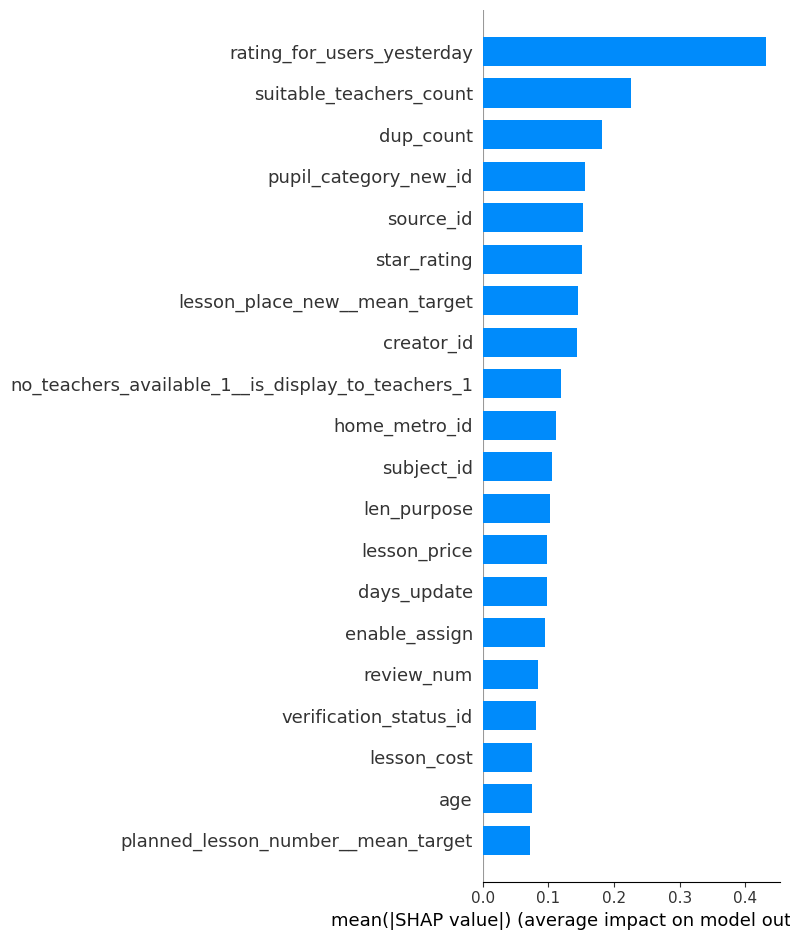

In [74]:
#Выведем график важности признаков
shap.summary_plot(shap_values, X_train, plot_type='bar')

Как мы видим по графику, среди важных оказались в том числе те признаки, которые мы синтезировали. Признак lesson_cost относится к учителям, так что он не является утечкой данных. Дальше применем полученные значения на практике.

In [75]:
#Для начала, нам надо вытащить числовые знаяения важности признаков. К сожалению, это делается не очень просто или мы не нашли простого способа
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
#Сортируем наш список признаков так, чтобы наверху были самые важные 
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
#Перобразем в список
shap_importance = shap_importance.reset_index(drop = True)
features = list(shap_importance['col_name'])
#Выведем получившийся результат
features

['rating_for_users_yesterday',
 'suitable_teachers_count',
 'dup_count',
 'pupil_category_new_id',
 'source_id',
 'star_rating',
 'lesson_place_new__mean_target',
 'creator_id',
 'no_teachers_available_1__is_display_to_teachers_1',
 'home_metro_id',
 'subject_id',
 'len_purpose',
 'lesson_price',
 'days_update',
 'enable_assign',
 'review_num',
 'verification_status_id',
 'lesson_cost',
 'age',
 'planned_lesson_number__mean_target',
 'month',
 'enable_auto_assign',
 'is_home_lessons',
 'minimal_price',
 'lessons_per_week__mean_target',
 'hour',
 'teacher_age_from',
 'day',
 'lesson_place_new',
 'is_external_lessons',
 'purpose_cluster__mean_target',
 'teacher_age_to',
 'isna',
 'lessons_per_week',
 'ejection',
 'purpose_cluster',
 'teacher_experience_from',
 'is_email_confirmed',
 'pupil_knowledgelvl',
 'teacher_sex_3__is_display_to_teachers_1',
 'teacher_sex',
 'teacher_sex_0__is_display_to_teachers_1',
 'weekday',
 'no_teachers_available',
 'planned_lesson_number',
 'pupil_knowledgel

Теперь будем обучать нашу модель и смотреть на лучший результат.


In [76]:
#Инциализируем переменную для лучших признаков и лучшего показателя roc_auc
best_roc_auc_score = 0
best_features = []

#Делим уже обучающую выборку на новую обучающую и валидационную
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Перебираем признаки
for i in tqdm(range(1,len(features))):
    #Оставляем признаки от нуля (самый важный) до минус шаг итерации (т.е. убираем признаки с конца списка)
    actual_features = features[0:-i]
    #Отбираем данные только с нужными признакми
    X_train_sample = X_train_[actual_features]
    X_val_sample = X_val[actual_features]
    
    #Создаём новую модель. В ней также меняем некоторые параметры, чтобы процесс не был слишком долгим
    model_temp = CatBoostClassifier(depth = 6,devices = '0:1', iterations = 1000,learning_rate = params['learning_rate'], task_type = 'GPU',
                                    random_seed=42 , silent = True,    grow_policy = params['grow_policy'])
    model_temp.fit(X_train_sample, y_train_,
          plot=False)
    pred = model_temp.predict(X_val_sample)
    #Считаем метрику
    actual_roc_auc_score = roc_auc_score(y_val, pred)
    
    #Если метрика лучше той, что до этого была лучшей, то обновляем метрику и список признаков
    if actual_roc_auc_score > best_roc_auc_score:
        best_roc_auc_score = actual_roc_auc_score
        best_features = actual_features
    
    #Удаляем временную модель
    del model_temp

#Выведем те признаки, которые оказались лишними
set(features) - set(best_features)

  0%|          | 0/67 [00:00<?, ?it/s]

{'no_teachers_available_1__is_display_to_teachers_0',
 'teacher_sex_0__is_display_to_teachers_0',
 'teacher_sex_0__no_teachers_available_1',
 'teacher_sex_1__is_display_to_teachers_0',
 'teacher_sex_1__no_teachers_available_1',
 'teacher_sex_2__is_display_to_teachers_0'}

### Финальная модель

Теперь уже обучим нашу финальную модель. Она будет использовать гиперпараметры, подобранные GridSearchCV (но мы увеличим количество итераций), а так же только те признаки, что мы отобраи выше.

In [77]:
model_final = CatBoostClassifier(depth = params['depth'],devices = '0:1', iterations = 5000,learning_rate = params['learning_rate'], 
                                 task_type = 'GPU',random_seed=42, grow_policy = params['grow_policy'] )
model_final.fit(X_train[best_features], y_train,
          plot=True)
pred = model_final.predict(X_test[best_features])


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6080434	total: 193ms	remaining: 16m 3s
1:	learn: 0.5680580	total: 388ms	remaining: 16m 10s
2:	learn: 0.5476123	total: 576ms	remaining: 15m 59s
3:	learn: 0.5350489	total: 770ms	remaining: 16m 1s
4:	learn: 0.5269996	total: 947ms	remaining: 15m 46s
5:	learn: 0.5212050	total: 1.13s	remaining: 15m 43s
6:	learn: 0.5171232	total: 1.3s	remaining: 15m 31s
7:	learn: 0.5134434	total: 1.49s	remaining: 15m 27s
8:	learn: 0.5095646	total: 1.67s	remaining: 15m 27s
9:	learn: 0.5063695	total: 1.84s	remaining: 15m 20s
10:	learn: 0.5031391	total: 2.01s	remaining: 15m 13s
11:	learn: 0.5009702	total: 2.18s	remaining: 15m 6s
12:	learn: 0.4986969	total: 2.33s	remaining: 14m 55s
13:	learn: 0.4959595	total: 2.5s	remaining: 14m 52s
14:	learn: 0.4936464	total: 2.67s	remaining: 14m 47s
15:	learn: 0.4915605	total: 2.83s	remaining: 14m 43s
16:	learn: 0.4889050	total: 3s	remaining: 14m 39s
17:	learn: 0.4865215	total: 3.17s	remaining: 14m 36s
18:	learn: 0.4848009	total: 3.33s	remaining: 14m 33s
19:	learn: 

Посмотрим показатели нашей модели

In [78]:
scoring(y_test, pred)

f1 0.6236816332680427
accuracy 0.8318345361583942
recall_score 0.5819552571920636
precision_score 0.6718537604739394
roc_auc_score 0.7462318171182636


Мы добились значения roc_auc_score 0.746, что является хорошим результатом. Экспериментально было выявлено, что созданные нами признаки положительно сказывались на модели.

Теперь построим график roc-auc для того, чтобы точнее увидеть результаты модели. Кроме того выведем таблицу со значениями истинно-положительных и истинно-отрицательных предсказаний в зависимости от порога.

In [79]:
#Инициализируем переменные
step = 0.05
probability = 0.0
tpr_list = []
tnr_list = []
fpr_list=[]
proba_list = []

#Делаем предсказания в зависимости от порога
for probability in tqdm(np.arange(0,1 + step,step)):
    #Меняем значения порога
    model_final.set_probability_threshold(probability )
    pred = model_final.predict(X_test)
    
    #Считаем метрики
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    fpr = fp/(fp+tn)
    fnr = fn/(tp+fn)
    tpr_list.append(tpr)
    tnr_list.append(tnr)
    fpr_list.append(fpr)
    proba_list.append(probability )

    

    


  0%|          | 0/21 [00:00<?, ?it/s]

Построим график roc-auc

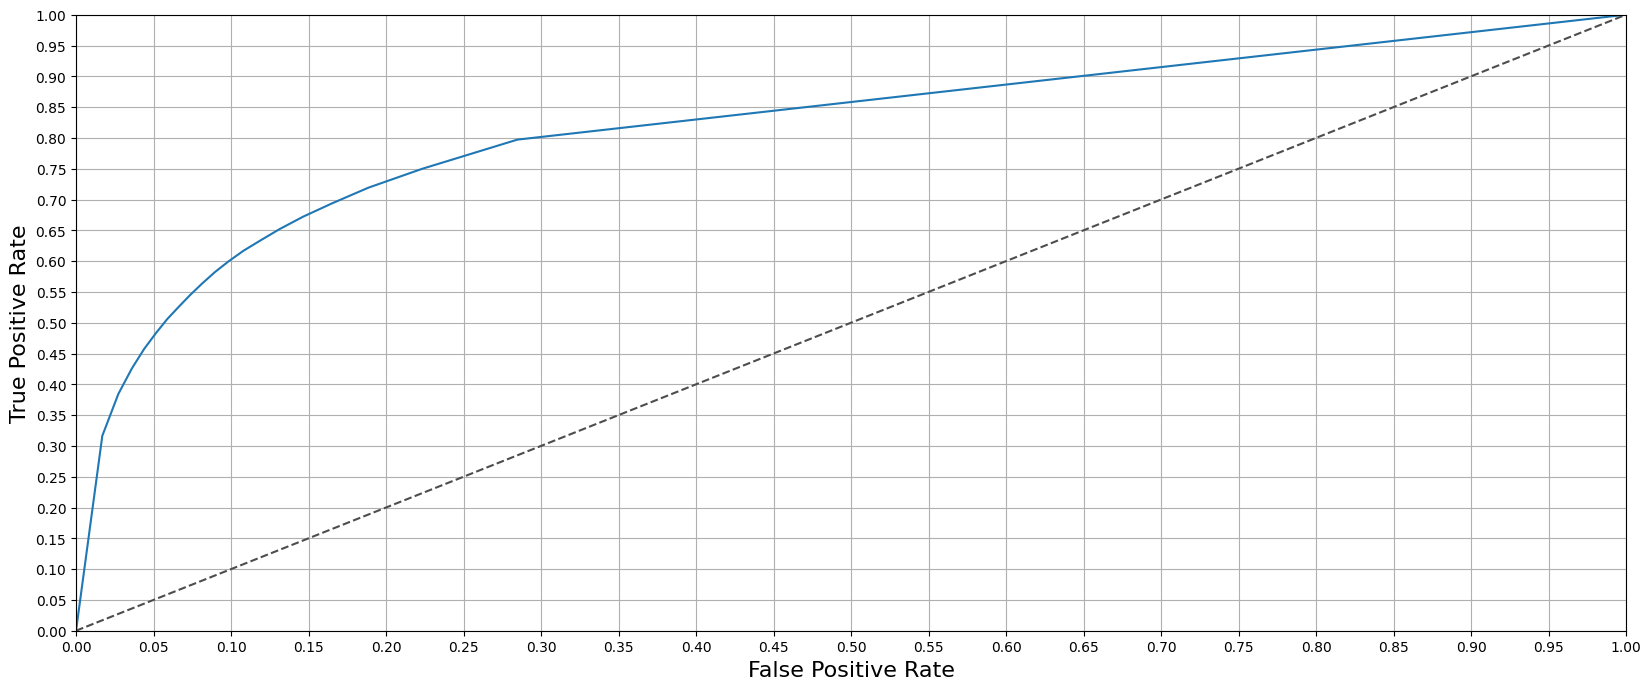

In [80]:
f, ax = plt.subplots(figsize=(20, 8))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(np.arange(0, 2, step))
plt.yticks(np.arange(0, 2, step))
plt.plot(fpr_list, tpr_list)
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.grid ( True )
plt.show()

Выведем таблицу, которая будет содержать пороговое значение, истинно-положительные и истинно-отрицательные значения. Это поможет заказчику лучше определить качество модели и выбрать подходящий порог. 

In [81]:
proba_table = pd.DataFrame({'Proba':proba_list,'TPR':tpr_list, 'TNR': tnr_list})
proba_table

,Proba,TPR,TNR
0,0.00,1.000000,0.000000
1,0.05,0.797251,0.715230
2,0.10,0.749802,0.776752
3,0.15,0.719277,0.811323
4,0.20,0.693724,0.834872
5,0.25,0.672109,0.853518
6,0.30,0.651952,0.868695
7,0.35,0.633692,0.880956
8,0.40,0.616751,0.892034
9,0.45,0.599283,0.901777


## Вывод

Мы изучили датасет и сумели также вытащить полезные признаки из двух других таблиц данных. Мы сумели выявить группы дублирующих заявок и правильно разметить их целевой признак, таким образом, решив проблему дублирующих заявок. Мы удалили признаки, неизвестные при создании заявок, таким образом частично решив проблему изменяющихся заявок. Мы очистили данные от непригодных для обучения значений, удалили самые разреженные признаки, вытащили признаки из дат и текстовых данных, а также создали дополнительные признаки на основе имеющихся. Кроме того, был произведён отбор признаков с помощью shap и обучена модель с наилучшими параметрами. В качестве финальной была выбрана модель cat_boost.  Мы добились метрик f1 = 0.623,
accuracy = 0.831, 
recall_score = 0.581,
precision_score = 0.671 и 
roc_auc_score = 0.746.
<br>
Кроме того, с помощью shap были выявлены важнейшие для модели признаки.

### Что может улучшить проект?

<b>Со стороны исполнителя:</b>
- улучшить обработку текстовых данных
- создать больше категориальных признаков, например, основываясь на имеющихся числовых и за их счёт создать больше синтетических признаков
- Попробовать синтезировать больше новых признаков, в том числе используя другие алгоритмы определения выбросов и т.п.

<b>Со стороны заказчика:</b>
- можно сохранять отдельно копии изменяющися заявок в первоначальном виде (отмечая также какая это итерация заявки и давая какой-нибудь общий id для всех итераций одной заявки). Тогда можно было бы более тонко настроить модели, например, обучив модель отдельно на всех заявках и только первоначальных.